In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import chi2_contingency

In [ ]:
# Load the dataset
dataset_path = '../data/raw/default_of_credit_card_clients.xls'
data = pd.read_excel(dataset_path, header=1)


# Convert specific columns to categorical types
categorical_features = [
    'SEX', 'EDUCATION', 'MARRIAGE',
    'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6',
    'default payment next month'
]

# Manually create the list of numerical features
numerical_features = ['LIMIT_BAL', 'AGE', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3',
                     'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

target = 'default payment next month'

for col in categorical_cols:
    data[col] = data[col].astype('category')
data['ID'] = data['ID'].astype(str)

# Map categorical codes to labels and replace unknown values with nan
data['SEX'] = data['SEX'].map({1: 'male', 2: 'female'}).astype('category')

data['EDUCATION'] = data['EDUCATION'].map({
    1: 'graduate school', 2: 'university', 3: 'high school', 4: 'others',
    5: np.nan, 6: np.nan, 0: np.nan
}).astype('category')

data['MARRIAGE'] = data['MARRIAGE'].map({
    1: 'married', 2: 'single', 3: 'divorce',
    0: np.nan
}).astype('category')


# Set a specific order for categorical variables
education_order = ['graduate school', 'high school', 'university', 'others']
data['EDUCATION'] = data['EDUCATION'].cat.reorder_categories(education_order, ordered=True)

# For MARRIAGE
marriage_order = ['single', 'married', 'divorce']
data['MARRIAGE'] = data['MARRIAGE'].cat.reorder_categories(marriage_order, ordered=True)


# Display the first few rows of the dataset
print(data.head())
print("Types: ", data.dtypes)

  ID  LIMIT_BAL     SEX   EDUCATION MARRIAGE  AGE PAY_0 PAY_2 PAY_3 PAY_4  \
0  1      20000  female  university  married   24     2     2    -1    -1   
1  2     120000  female  university   single   26    -1     2     0     0   
2  3      90000  female  university   single   34     0     0     0     0   
3  4      50000  female  university  married   37     0     0     0     0   
4  5      50000    male  university  married   57    -1     0    -1     0   

   ... BILL_AMT4 BILL_AMT5  BILL_AMT6  PAY_AMT1  PAY_AMT2  PAY_AMT3  PAY_AMT4  \
0  ...         0         0          0         0       689         0         0   
1  ...      3272      3455       3261         0      1000      1000      1000   
2  ...     14331     14948      15549      1518      1500      1000      1000   
3  ...     28314     28959      29547      2000      2019      1200      1100   
4  ...     20940     19146      19131      2000     36681     10000      9000   

   PAY_AMT5  PAY_AMT6  default payment next month 

In [8]:
# Check for missing values and unique values
print("Missing values: ", data.isnull().sum())

Missing values:  ID                              0
LIMIT_BAL                       0
SEX                             0
EDUCATION                     345
MARRIAGE                       54
AGE                             0
PAY_0                           0
PAY_2                           0
PAY_3                           0
PAY_4                           0
PAY_5                           0
PAY_6                           0
BILL_AMT1                       0
BILL_AMT2                       0
BILL_AMT3                       0
BILL_AMT4                       0
BILL_AMT5                       0
BILL_AMT6                       0
PAY_AMT1                        0
PAY_AMT2                        0
PAY_AMT3                        0
PAY_AMT4                        0
PAY_AMT5                        0
PAY_AMT6                        0
default payment next month      0
dtype: int64


In [23]:
# Remove rows with any missing values and print how many rows were discarded
initial_shape = data.shape
data = data.dropna()
final_shape = data.shape
print(f"Removed {initial_shape[0] - final_shape[0]} rows with missing values.")

Removed 399 rows with missing values.


Analysis of Categorical Variables

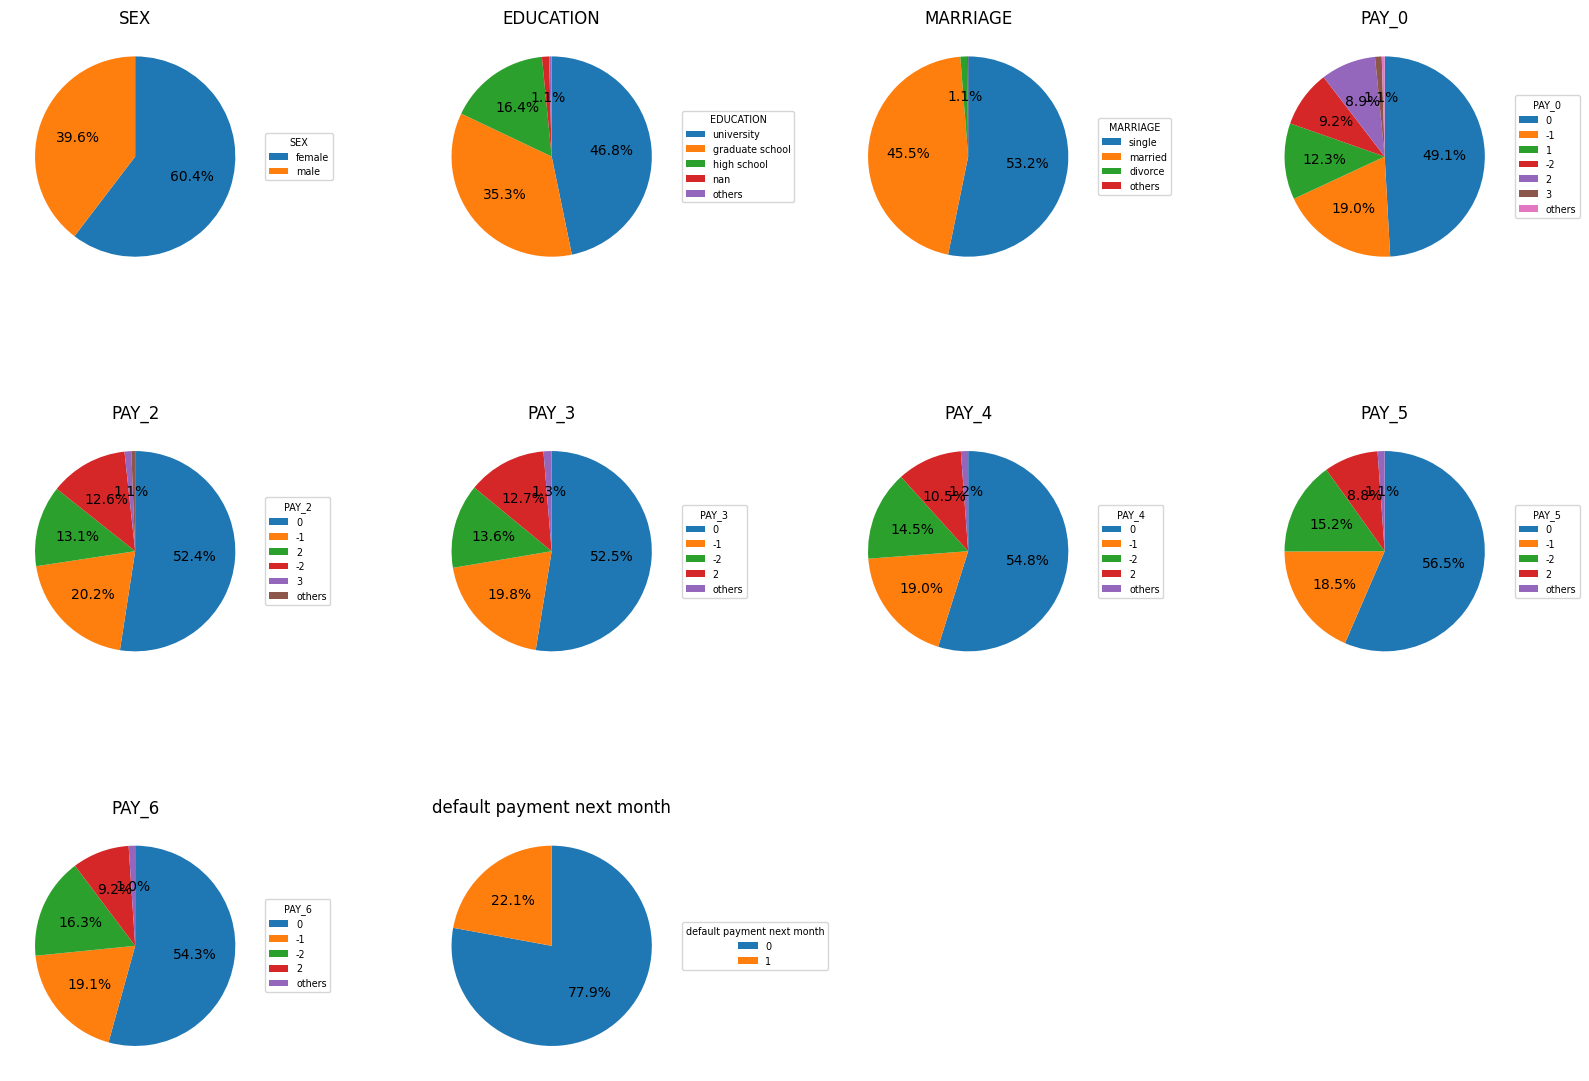

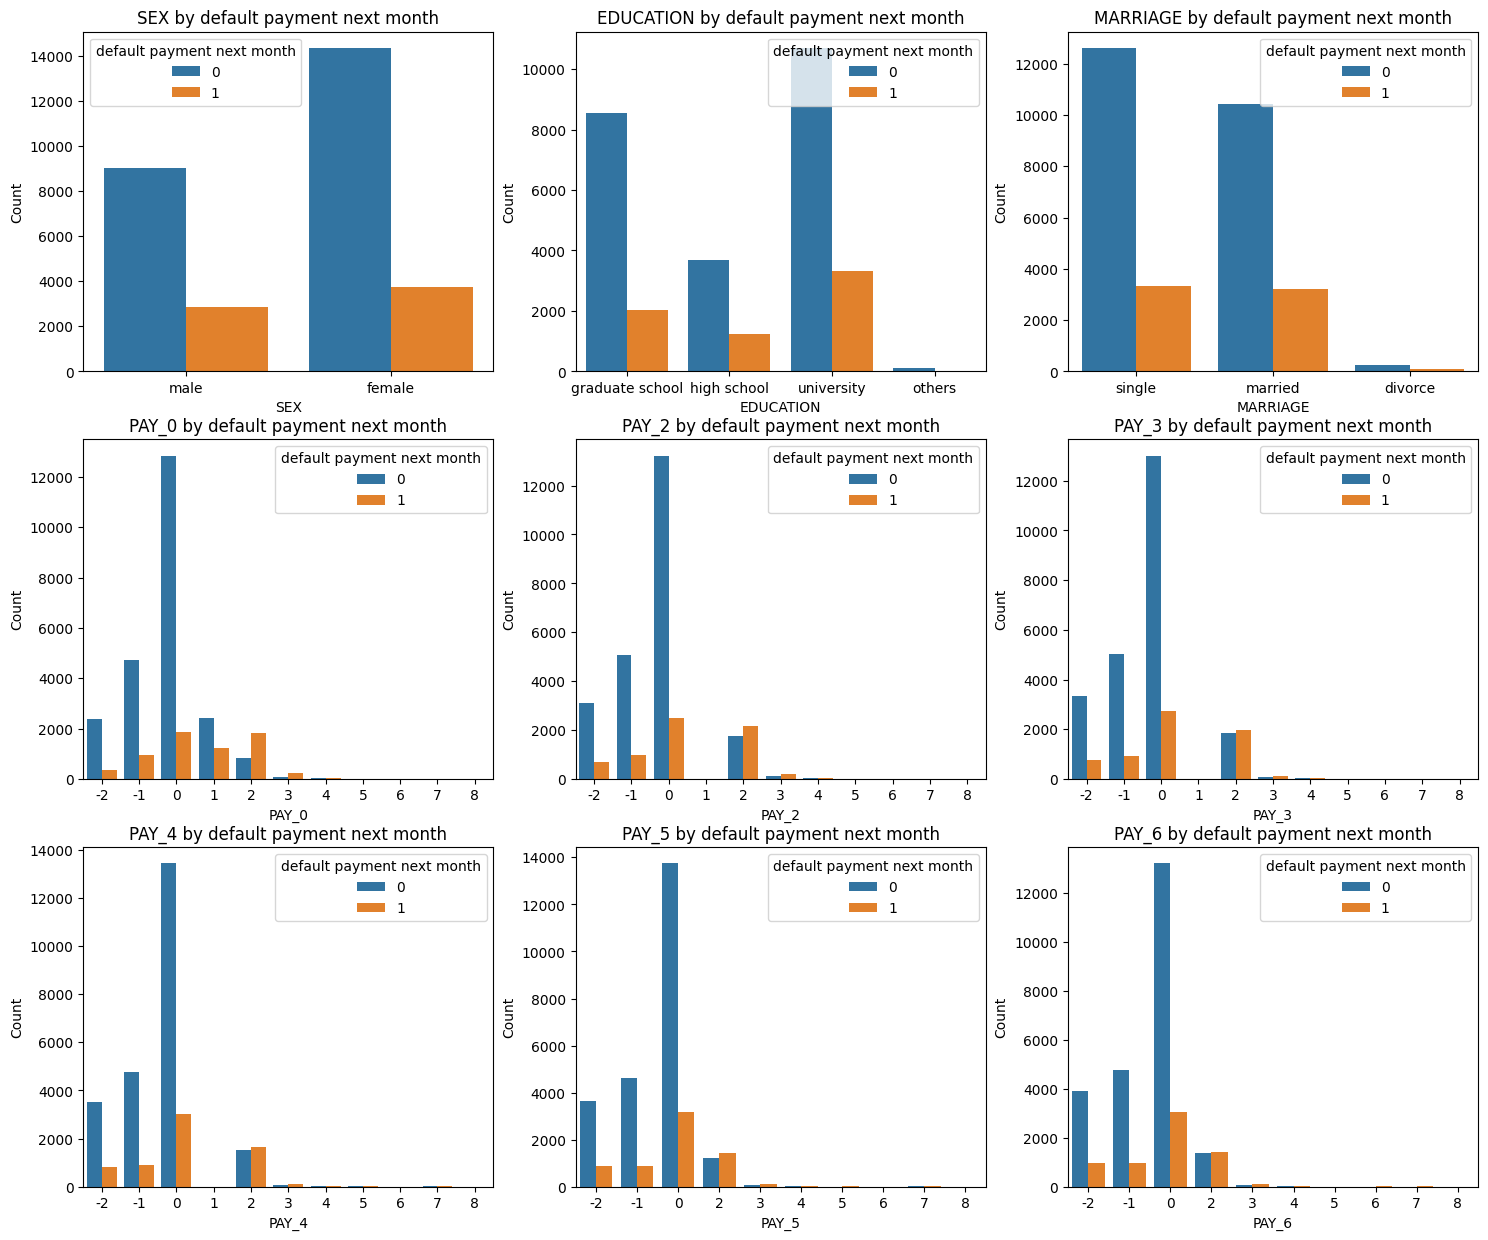

In [18]:
# Panel of pie plots for the categorical variables with smaller legend box, smaller pies, and grouping <1% as 'others'
target = 'default payment next month'
categorical_cols = [col for col in data.select_dtypes(include='category').columns if col != target]+[target]

n_cols = 4
n_rows = int(np.ceil(len(categorical_cols) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows))  # smaller pies

for idx, col in enumerate(categorical_cols):
    ax = axes[idx // n_cols, idx % n_cols]
    counts = data[col].value_counts(dropna=False)
    total = counts.sum()
    percentages = counts / total
    # Group categories below 1% as 'others'
    mask = percentages < 0.01
    if mask.any():
        others_count = counts[mask].sum()
        counts = counts[~mask]
        counts['others'] = others_count
    labels = [str(i) for i in counts.index]
    wedges, texts, autotexts = ax.pie(
        counts,
        labels=None,
        autopct=lambda pct: ('%1.1f%%' % pct) if pct >= 1 else '',
        startangle=90,
        counterclock=False
    )
    ax.set_title(col)
    ax.set_ylabel('')
    # Place the legend to the right of the pie and make the font smaller
    ax.legend(
        wedges, labels, title=col,
        loc='center left', bbox_to_anchor=(1, 0.5),
        fontsize='x-small', title_fontsize='x-small'
    )

# Remove empty subplots if any
for j in range(idx + 1, n_rows * n_cols):
    fig.delaxes(axes[j // n_cols, j % n_cols])

plt.tight_layout()
plt.show()


# Panel of categorical variable distributions by target

target = 'default payment next month'
categorical_cols = [col for col in data.select_dtypes(include='category').columns if col != target]

n_cols = 3
n_rows = int(np.ceil(len(categorical_cols) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 5 * n_rows))

for idx, col in enumerate(categorical_cols):
    ax = axes[idx // n_cols, idx % n_cols]
    sns.countplot(x=col, hue=target, data=data, ax=ax)
    ax.set_title(f'{col} by {target}')
    ax.legend(title=target)
    ax.set_xlabel(col)
    ax.set_ylabel('Count')

# Remove empty subplots if any
for j in range(idx + 1, n_rows * n_cols):
    fig.delaxes(axes[j // n_cols, j % n_cols])




In [73]:
# Analysis of Categorical Variables with respect to the target

target = 'default payment next month'
categorical_cols = [col for col in data.select_dtypes(include='category').columns if col != target]

for col in categorical_cols:
    print(f"--- {col} ---")
    print("Counts:\n", data[col].value_counts(dropna=False))
    print("Proportions:\n", data[col].value_counts(normalize=True, dropna=False))
    print("Unique values:", data[col].unique())
    print("\n")
    

--- SEX ---
Counts:
 SEX
female    18112
male      11888
Name: count, dtype: int64
Proportions:
 SEX
female    0.603733
male      0.396267
Name: proportion, dtype: float64
Unique values: ['female', 'male']
Categories (2, object): ['male', 'female']


--- EDUCATION ---
Counts:
 EDUCATION
university         14030
graduate school    10585
high school         4917
NaN                  345
others               123
Name: count, dtype: int64
Proportions:
 EDUCATION
university         0.467667
graduate school    0.352833
high school        0.163900
NaN                0.011500
others             0.004100
Name: proportion, dtype: float64
Unique values: ['university', 'graduate school', 'high school', NaN, 'others']
Categories (4, object): ['graduate school' < 'high school' < 'university' < 'others']


--- MARRIAGE ---
Counts:
 MARRIAGE
single     15964
married    13659
divorce      323
NaN           54
Name: count, dtype: int64
Proportions:
 MARRIAGE
single     0.532133
married    0.455300
divor

In [80]:
for col in categorical_cols:
    contingency = pd.crosstab(data[col], data[target])
    chi2, p, dof, ex = chi2_contingency(contingency)
    
    # Check minimum expected frequency
    min_expected = np.min(ex)
    
    print(f"\n--- {col} ---")
    print(f"Chi-square: {chi2:.2f}")
    print(f"p-value: {p:.2e}")
    print(f"Minimum expected frequency: {min_expected:.2f}")
    
    # Calculate effect size (Cramér's V)
    n = contingency.sum().sum()
    phi2 = chi2/n
    r, k = contingency.shape
    cramers_v = np.sqrt(phi2/min(k-1, r-1))
    
    print(f"Cramér's V: {cramers_v:.4f}")


--- SEX ---
Chi-square: 47.71
p-value: 4.94e-12
Minimum expected frequency: 2629.63
Cramér's V: 0.0399

--- EDUCATION ---
Chi-square: 116.86
p-value: 3.66e-25
Minimum expected frequency: 27.42
Cramér's V: 0.0628

--- MARRIAGE ---
Chi-square: 30.45
p-value: 2.45e-07
Minimum expected frequency: 71.52
Cramér's V: 0.0319

--- PAY_0 ---
Chi-square: 5365.96
p-value: 0.00e+00
Minimum expected frequency: 1.99
Cramér's V: 0.4229

--- PAY_2 ---
Chi-square: 3474.47
p-value: 0.00e+00
Minimum expected frequency: 0.22
Cramér's V: 0.3403

--- PAY_3 ---
Chi-square: 2622.46
p-value: 0.00e+00
Minimum expected frequency: 0.66
Cramér's V: 0.2957

--- PAY_4 ---
Chi-square: 2341.47
p-value: 0.00e+00
Minimum expected frequency: 0.44
Cramér's V: 0.2794

--- PAY_5 ---
Chi-square: 2197.69
p-value: 0.00e+00
Minimum expected frequency: 0.22
Cramér's V: 0.2707

--- PAY_6 ---
Chi-square: 1886.84
p-value: 0.00e+00
Minimum expected frequency: 0.44
Cramér's V: 0.2508

--- default payment next month ---
Chi-square: 29

Numerica features Analysis

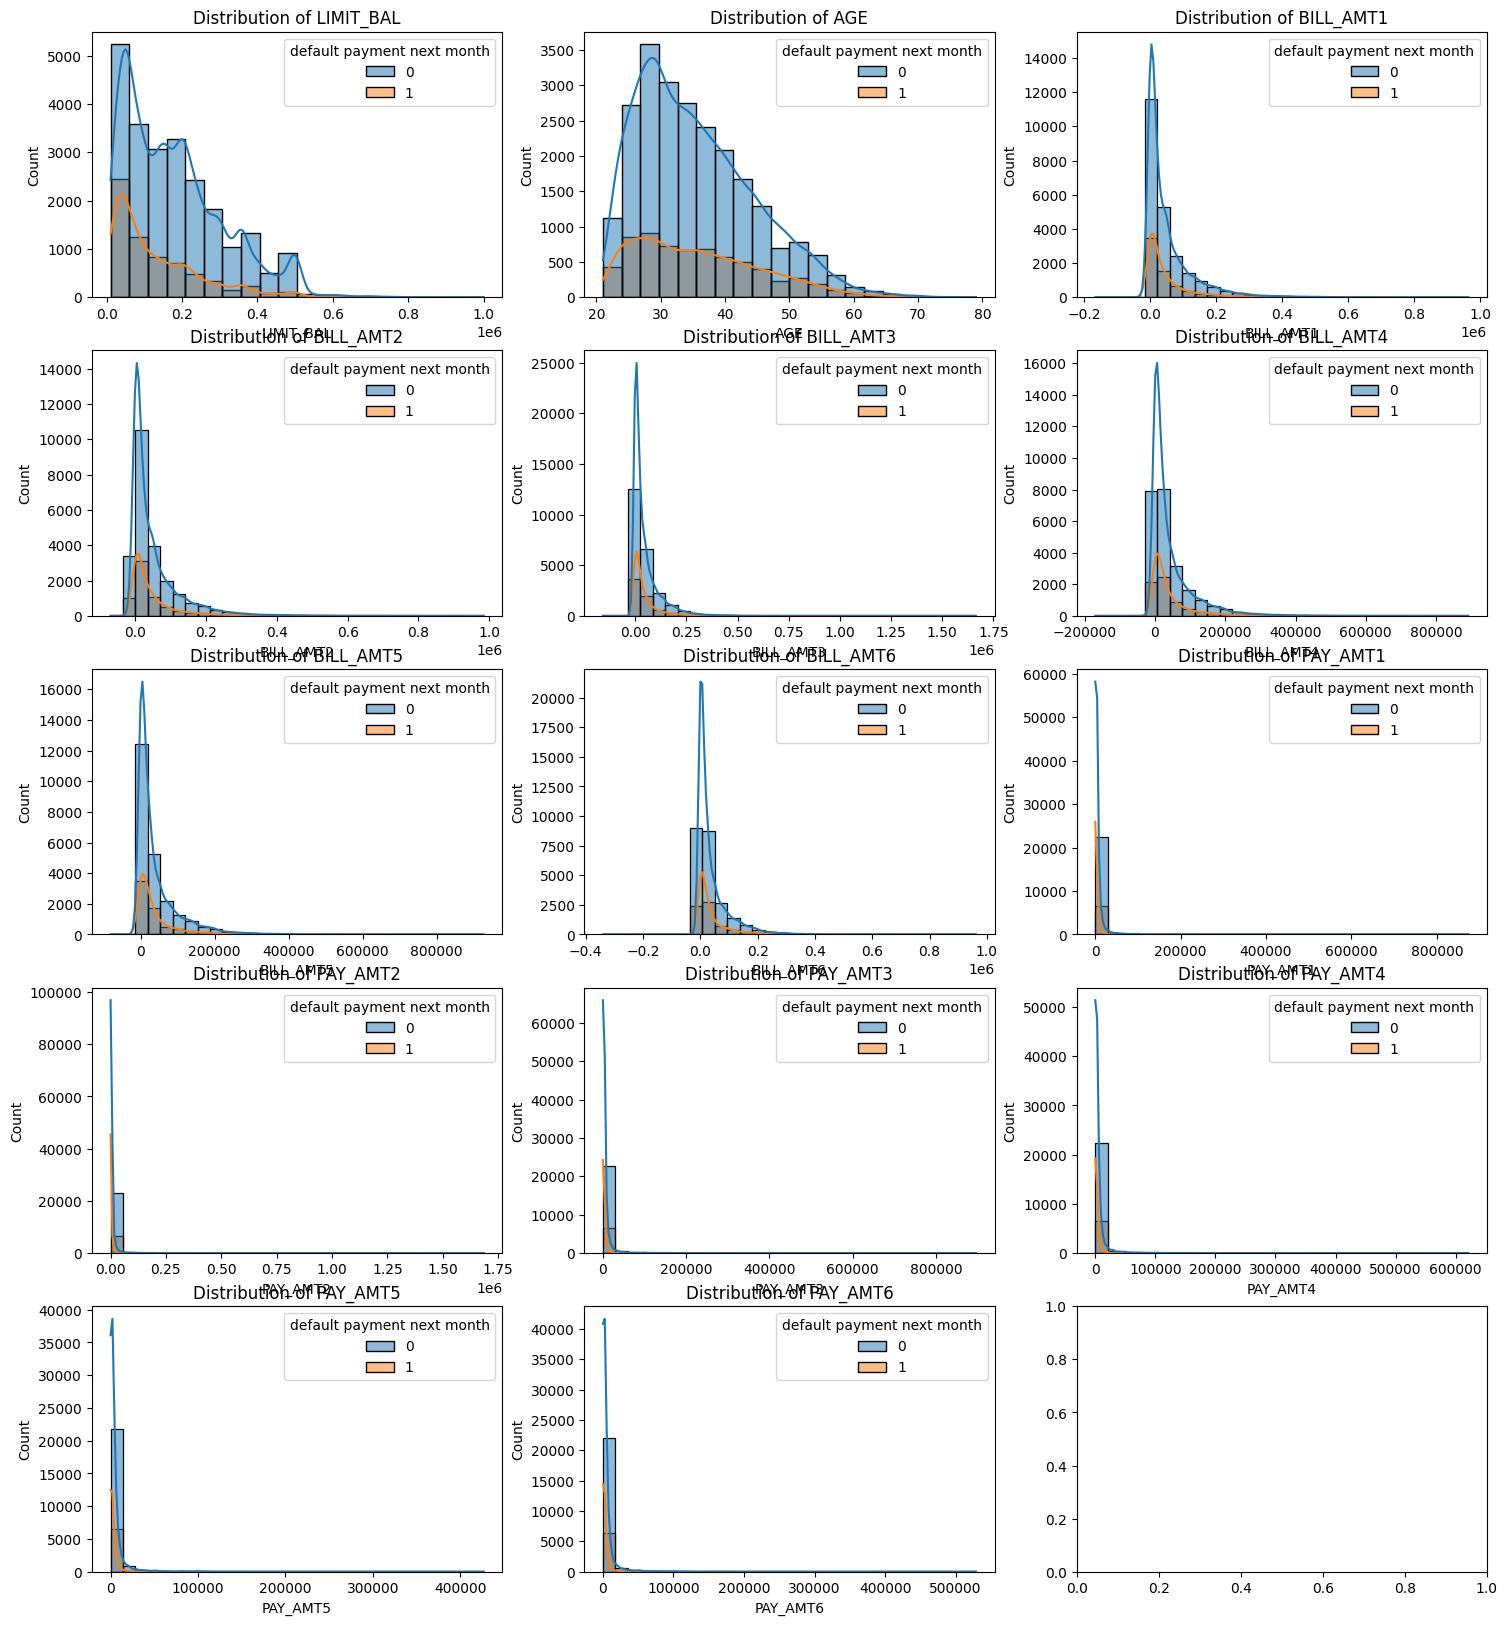

In [ ]:
# Panel of numerical feature distributions by target, with custom bins

numerical_features = ['LIMIT_BAL', 'AGE', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',
                      'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

# Suggest bins for each feature based on their value ranges
bins_dict = {
    'LIMIT_BAL': 20,
    'AGE': 20,
    'BILL_AMT1': 30,
    'BILL_AMT2': 30,
    'BILL_AMT3': 30,
    'BILL_AMT4': 30,
    'BILL_AMT5': 30,
    'BILL_AMT6': 30,
    'PAY_AMT1': 30,
    'PAY_AMT2': 30,
    'PAY_AMT3': 30,
    'PAY_AMT4': 30,
    'PAY_AMT5': 30,
    'PAY_AMT6': 30
}

n_cols = 3
n_rows = int(np.ceil(len(numerical_features) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 4 * n_rows))

for idx, col in enumerate(numerical_features):
    ax = axes[idx // n_cols, idx % n_cols]
    bins = bins_dict.get(col, 30)
    sns.histplot(data, x=col, hue='default payment next month', bins=bins, kde=True, ax=ax)
    ax.set_title(f'Distribution of {col}')

Text(0.5, 1.0, 'Correlation Matrix')

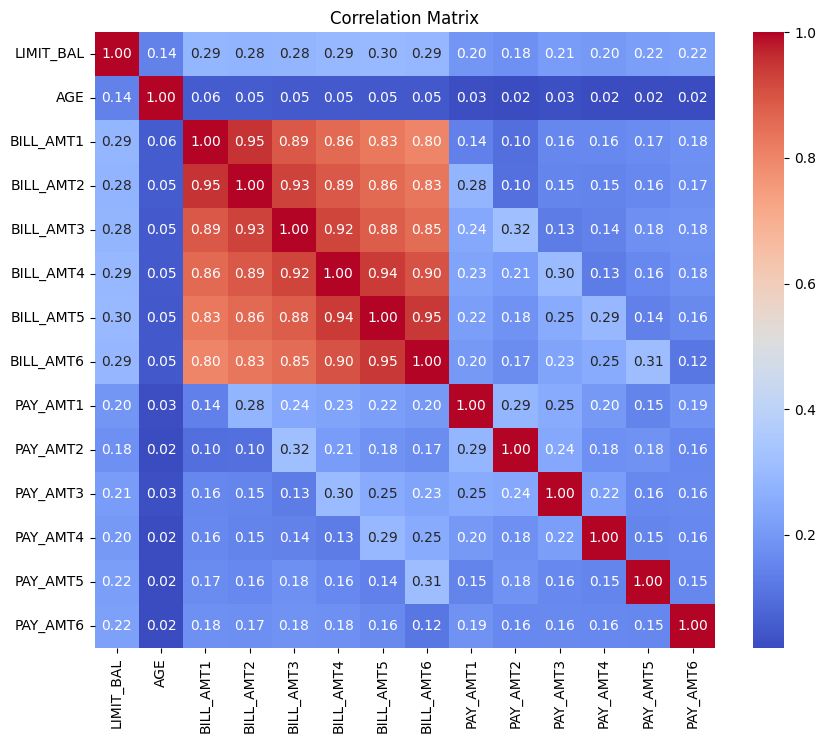

In [21]:
# Correlation heatmap with all data
plt.figure(figsize=(10, 8))
sns.heatmap(data[numerical_features].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')

In [87]:
print(data.describe)

<bound method NDFrame.describe of           ID  LIMIT_BAL     SEX    EDUCATION MARRIAGE  AGE PAY_0 PAY_2 PAY_3  \
0          1      20000  female   university  married   24     2     2    -1   
1          2     120000  female   university   single   26    -1     2     0   
2          3      90000  female   university   single   34     0     0     0   
3          4      50000  female   university  married   37     0     0     0   
4          5      50000    male   university  married   57    -1     0    -1   
...      ...        ...     ...          ...      ...  ...   ...   ...   ...   
29995  29996     220000    male  high school  married   39     0     0     0   
29996  29997     150000    male  high school   single   43    -1    -1    -1   
29997  29998      30000    male   university   single   37     4     3     2   
29998  29999      80000    male  high school  married   41     1    -1     0   
29999  30000      50000    male   university  married   46     0     0     0   

     